<a href="https://colab.research.google.com/github/davidrtorres/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/blob/master/starter_notebook_11_21_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
"""
you will be forecasting real estate prices of various zip codes 

What are the top 5 best zip codes for us to invest in?

Should your recommendation be focused on profit margins only? 
What about risk? 
What sort of time horizon are you predicting against? 
Your recommendation will need to detail your rationale and answer any sort of lingering questions like these 
    in order to demonstrate how you define "best".

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), 
    you need to start with a definition of "best investment". 
    Consider additional metrics like risk vs. profitability, or ROI yield.


"""
print('Colab Notebook 11-18-20')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

Colab Notebook 11-18-20


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
# #pd.set_option('display.max_columns', None)  
# zillow = pd.read_csv('zillow_data.csv')
# zillow.head()
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
zillow = pd.read_csv('/content/gdrive/My Drive/data/zillow_data.csv') 

In [5]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,...,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,...,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,...,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,...,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,77900.0,77900.0,77800.0,77800.0,77800.0,77800.0,77800.0,77900.0,78100.0,78200.0,78400.0,78600.0,78800.0,79000.0,79100.0,79200.0,79300.0,79300.0,79300.0,79400.0,79500.0,79500.0,79600.0,...,114700,115000,115000,115200,115600,115900,115600,115400,115400,115500,115800,116300,116200,115600,115000,114500,114200,114000,114000,113900,114100,114900,115700,116300,116900,117300,117600,118000,118600,118900,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [7]:
all_zipcodes = melt_data(zillow)

In [8]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [9]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [10]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
10,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
13,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
47,62040,11230,New York,NY,New York,Kings,48,1996-04-01,230100.0
49,62020,11209,New York,NY,New York,Kings,50,1996-04-01,255700.0
53,62023,11212,New York,NY,New York,Kings,54,1996-04-01,125000.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [11]:
test_dict = {}

# for zipcode in kings_zips['Zipcode'].unique(): 
#     all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
#     all_zips = all_zips.set_index('Month')['MeanValue']
#     all_zips = all_zips.asfreq('MS')
#     all_zips.name = zipcode
#     test_dict[zipcode] = all_zips
for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips
    

In [12]:
test_dict

{11203: Month
 1996-04-01    149000.0
 1996-05-01    149200.0
 1996-06-01    149400.0
 1996-07-01    149600.0
 1996-08-01    149700.0
                 ...   
 2017-12-01    474500.0
 2018-01-01    475300.0
 2018-02-01    474800.0
 2018-03-01    481000.0
 2018-04-01    489900.0
 Freq: MS, Name: 11203, Length: 265, dtype: float64, 11204: Month
 1996-04-01    201100.0
 1996-05-01    201100.0
 1996-06-01    201100.0
 1996-07-01    201100.0
 1996-08-01    201100.0
                 ...   
 2017-12-01    958900.0
 2018-01-01    963200.0
 2018-02-01    967900.0
 2018-03-01    972800.0
 2018-04-01    976400.0
 Freq: MS, Name: 11204, Length: 265, dtype: float64, 11205: Month
 2004-01-01     833100.0
 2004-02-01     821400.0
 2004-03-01     812000.0
 2004-04-01     805500.0
 2004-05-01     801400.0
                 ...    
 2017-12-01    2251000.0
 2018-01-01    2251600.0
 2018-02-01    2245300.0
 2018-03-01    2243700.0
 2018-04-01    2248400.0
 Freq: MS, Name: 11205, Length: 172, dtype: float64

In [13]:
zip_df = pd.concat(test_dict, axis=1)

In [14]:
len(zip_df)

265

In [15]:
zip_df.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,11211,11233,11236,11218,11223,11208,11204,11219,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-04-01,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,133200.0,124500.0,160900.0,177200.0,207600.0,126800.0,201100.0,213200.0,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,219300.0,NaN,NaN,NaN
1996-05-01,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,132900.0,124500.0,161000.0,177000.0,208000.0,126700.0,201100.0,212600.0,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,219600.0,NaN,NaN,NaN
1996-06-01,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,132500.0,124500.0,161200.0,176800.0,208400.0,126700.0,201100.0,211900.0,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,219900.0,NaN,NaN,NaN
1996-07-01,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,132200.0,124500.0,161300.0,176700.0,208800.0,126600.0,201100.0,211300.0,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,220200.0,NaN,NaN,NaN
1996-08-01,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,131800.0,124700.0,161500.0,176800.0,209300.0,126600.0,201100.0,210800.0,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,220600.0,NaN,NaN,NaN


In [16]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,11211,11233,11236,11218,11223,11208,11204,11219,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,1463100.0,809800.0,453600.0,1186400.0,947800.0,435400.0,958900.0,1016000.0,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,1496100.0,800800.0,458400.0,1174500.0,952100.0,429900.0,963200.0,1014400.0,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,1531100.0,806100.0,461600.0,1173900.0,966600.0,432300.0,967900.0,1023800.0,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,1581900.0,829200.0,467200.0,1196100.0,997000.0,442400.0,972800.0,1053000.0,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,1623700.0,852300.0,472000.0,1220900.0,1026600.0,450600.0,976400.0,1079600.0,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [17]:
len(zip_df.columns)

28

In [18]:
#zip_df[11238]
zip_df = zip_df[[11226,11235,11238]]

In [19]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [20]:
zip_df.isna().sum()

11226     0
11235     0
11238    93
dtype: int64

In [21]:
zip_df.bfill(inplace=True)

In [22]:
zip_df.isna().sum()

11226    0
11235    0
11238    0
dtype: int64

In [23]:
zip_df[11238].value_counts(dropna=False)

671200.0     94
1177800.0     2
1839100.0     1
1033400.0     1
2530000.0     1
             ..
2346900.0     1
665400.0      1
1237600.0     1
1361500.0     1
1638400.0     1
Name: 11238, Length: 171, dtype: int64

In [24]:
zip_df.keys()

Int64Index([11226, 11235, 11238], dtype='int64')

In [25]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

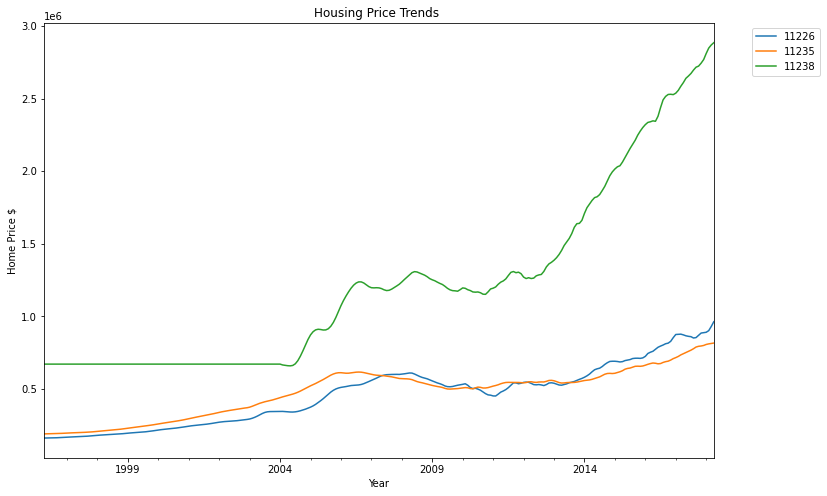

In [26]:
"""

2007–08 Housing Market Crash
"""
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Price $')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

## **Train/Test Split**

In [27]:
"""
 train data set is from 1996–04–01 to 2014–01–01. The length of our test data we get 214 rows, or 214 time periods. 
 
 test data set is from 2014–01–01 to 2018–04–01. The length of our test data we get 52 rows, or 52 time periods. 
 That is the value will use for our .predict() method 

"""
year = '2014-01-01'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

In [28]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(214, 3)
(52, 3)


In [29]:
train_brk.tail()

,11226,11235,11238
Month,,,
2013-09-01,551600.0,545200.0,1613500.0
2013-10-01,558900.0,547300.0,1638400.0
2013-11-01,566200.0,550600.0,1640700.0
2013-12-01,572600.0,554600.0,1661500.0
2014-01-01,580700.0,558200.0,1709200.0


In [30]:
test_brk.head()

,11226,11235,11238
Month,,,
2014-01-01,580700.0,558200.0,1709200.0
2014-02-01,590500.0,560000.0,1748800.0
2014-03-01,602600.0,562300.0,1773300.0
2014-04-01,618300.0,566300.0,1798700.0
2014-05-01,632300.0,572000.0,1818100.0


### **Auto_Arima Model**

In [31]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [32]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 9.9MB/s 
     |████████████████████████████████| 2.1MB 40.9MB/s 
     |████████████████████████████████| 808kB 29.8MB/s 
     |████████████████████████████████| 8.7MB 30.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [33]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [34]:
#stepwise_fit = auto_arima(train_brk[11220],start_p=0, start_q=0,max_p=6,max_q=3, trace=True)

def arima_model(df):
    autoarima_model = auto_arima(df, start_p = 0, start_q = 1, 
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = 1,               # let model determine 'd'
                              seasonal = True, 
                              start_P=0, D=1, trace = True, #start 0
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    print('\n')
    display(autoarima_model.summary())
    
    return autoarima_model


In [35]:
stepwise_fit = arima_model(train_brk[11226])

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4116.531, Time=1.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4186.338, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4111.966, Time=1.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4211.321, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4147.894, Time=1.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4104.096, Time=1.05 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=4132.912, Time=1.63 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=6.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4162.447, Time=0.22 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4158.454, Time=0.55 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4092.751, Time=2.63 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4127.548, Time=0.60 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(1,1,1)(0,1,2)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2038.094
Date:                            Sun, 22 Nov 2020   AIC                           4086.188
Time:                                    21:13:33   BIC                           4102.705
Sample:                                         0   HQIC                          4092.871
                                            - 214                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7137      0.058     12.407      0.000       0.601       0.826
ma.L1         -0.4503      0.059     -7.686      0.000      -0.565      -0.335
ma.S.L12      -0.3650      0.023    -15.883      0.000      -0.410      -0.320
ma.S.L24      -0.1213      0.014     -8.872      0.000      -0.148      -0.095
sigma2      3.688e+07   1.65e-10   2.23e+17      0.000    3.69e+07    3.69e+07
===================================================================================
Ljung-Box (Q):                      181.53   Jarque-Bera (JB):               133.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.85e+32. Standard errors may be unstable.
"""

In [36]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2038.094
Date:                            Sun, 22 Nov 2020   AIC                           4086.188
Time:                                    21:13:34   BIC                           4102.705
Sample:                                         0   HQIC                          4092.871
                                            - 214                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7137      0.058     12.407      0.000       0.601       0.826
ma.L1         -0.4503      0.059     -7.686      0.000      -0.565      -0.335
ma.S.L12      -0.3650      0.023    -15.883      0.000      -0.410      -0.320
ma.S.L24      -0.1213      0.014     -8.872      0.000      -0.148      -0.095
sigma2      3.688e+07   1.65e-10   2.23e+17      0.000    3.69e+07    3.69e+07
===================================================================================
Ljung-Box (Q):                      181.53   Jarque-Bera (JB):               133.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.85e+32. Standard errors may be unstable.
"""

In [37]:
# #arima_dic_2 = {}
# col = 11238
# #for col in zip_df.columns:
# zip_test_2 = arima_model(zip_df[col])
# #arima_dic_2[col] = zip_test_2
  
# # output_2 = pd.DataFrame(arima_dic_2.items(), columns =['Zipcode_pdq','pdq']) 
# # output_2   

In [38]:
# #zipcode
# #aic
# #order
# my_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
# #zip_test_2.order
# #zip_test_2.aic()
# my_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])

In [39]:
#my_list

In [40]:
# sample = pd.DataFrame(my_list[1:],columns=my_list[0])
# sample.head()

### **DataFrame of Zipcodes w/pdqs and AICs**

In [41]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  #arima_dic_2[col] = zip_test_2
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5217.526, Time=0.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5324.110, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5210.861, Time=1.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5292.651, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5215.212, Time=1.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5194.092, Time=0.97 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5208.395, Time=0.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5195.883, Time=3.98 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5195.906, Time=3.72 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5198.366, Time=2.08 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=5.91 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.28 sec
 ARIMA(0,1,1)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2593.046
Date:                            Sun, 22 Nov 2020   AIC                           5194.092
Time:                                    21:14:08   BIC                           5208.210
Sample:                                         0   HQIC                          5199.773
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3688      0.010     37.281      0.000       0.349       0.388
ar.S.L12       0.3880      0.022     17.778      0.000       0.345       0.431
ma.S.L12      -0.8531      0.031    -27.796      0.000      -0.913      -0.793
sigma2      3.679e+07   1.93e-10   1.91e+17      0.000    3.68e+07    3.68e+07
===================================================================================
Ljung-Box (Q):                      155.59   Jarque-Bera (JB):               235.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4905.170, Time=1.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4924.283, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4903.177, Time=1.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4904.292, Time=0.24 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5009.782, Time=1.83 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4902.792, Time=1.47 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5005.263, Time=2.01 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=6.75 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4926.793, Time=0.35 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4899.299, Time=1.98 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=4901.239, Time=0.67 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=4894.359, Time=5.30 sec
 ARIMA(2,1,0)(1,1,2)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2436.931
Date:                            Sun, 22 Nov 2020   AIC                           4885.863
Time:                                    21:16:44   BIC                           4907.039
Sample:                                         0   HQIC                          4894.384
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0412      0.035     30.015      0.000       0.973       1.109
ar.L2         -0.0720      0.015     -4.930      0.000      -0.101      -0.043
ma.L1         -0.9094      0.027    -33.969      0.000      -0.962      -0.857
ma.S.L12      -0.1413      0.016     -8.942      0.000      -0.172      -0.110
ma.S.L24      -0.0753      0.008     -8.924      0.000      -0.092      -0.059
sigma2      1.436e+07   6.39e-10   2.25e+16      0.000    1.44e+07    1.44e+07
===================================================================================
Ljung-Box (Q):                      218.74   Jarque-Bera (JB):                23.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5633.957, Time=0.68 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5623.498, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5728.223, Time=0.70 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5621.510, Time=0.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5617.100, Time=2.43 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.12 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5714.817, Time=1.85 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5627.427, Time=1.09 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5792.665, Time=2.28 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5616.332, Time=2.06 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=5619.948, Time=0.29 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=5608.526, Time=3.14 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=5609.512, Time=1.14 sec
 ARIMA(0,1,0)(2,1,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 2, 12)   Log Likelihood               -2795.831
Date:                            Sun, 22 Nov 2020   AIC                           5603.661
Time:                                    21:18:27   BIC                           5624.838
Sample:                                         0   HQIC                          5612.182
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    756.8316    172.654      4.384      0.000     418.436    1095.228
ma.L1          0.1096      0.005     21.805      0.000       0.100       0.119
ar.S.L12       0.5487      0.035     15.776      0.000       0.481       0.617
ma.S.L12      -0.7838      0.044    -17.634      0.000      -0.871      -0.697
ma.S.L24      -0.0448      0.014     -3.229      0.001      -0.072      -0.018
sigma2      1.552e+08      0.001    1.4e+11      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (Q):                      294.73   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               2.65   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+26. Standard errors may be unstable.
"""

,zipcode,pdq,seasonal_pdq,aic
0,11226,"(1, 1, 0)","(1, 1, 1, 12)",5194.092117
1,11235,"(2, 1, 1)","(0, 1, 2, 12)",4885.862508
2,11238,"(0, 1, 1)","(1, 1, 2, 12)",5603.661287


In [42]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zipcode       3 non-null      int64  
 1   pdq           3 non-null      object 
 2   seasonal_pdq  3 non-null      object 
 3   aic           3 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 224.0+ bytes


In [43]:
output_df[:2]

,zipcode,pdq,seasonal_pdq,aic
0,11226,"(1, 1, 0)","(1, 1, 1, 12)",5194.092117
1,11235,"(2, 1, 1)","(0, 1, 2, 12)",4885.862508


In [44]:
output_df['zipcode'] == 11238

0    False
1    False
2     True
Name: zipcode, dtype: bool

## **SARIMA Model**

### **Fitting an ARIMA TS Model**

In [45]:
"""
Using grid search, we have identified the set of parameters that produces the best fitting model 
    to our time series data. 
plug in the optimal parameter values into a new SARIMAX model.    

coef column above shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.

each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

model diagnostics-The purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.
where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.
"""
def fit_ARIMA(df, order=None, seasonal_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    print(output.summary().tables[1])
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    
    return output

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7363      0.053     13.937      0.000       0.633       0.840
ar.S.L12      -0.2718      0.579     -0.469      0.639      -1.407       0.863
ma.S.L12      -0.2032      0.565     -0.360      0.719      -1.311       0.905
ma.S.L24       0.0211      0.262      0.081      0.936      -0.492       0.534
sigma2      1.558e+08   1.18e-09   1.32e+17      0.000    1.56e+08    1.56e+08


MODEL DIAGNOSTICS


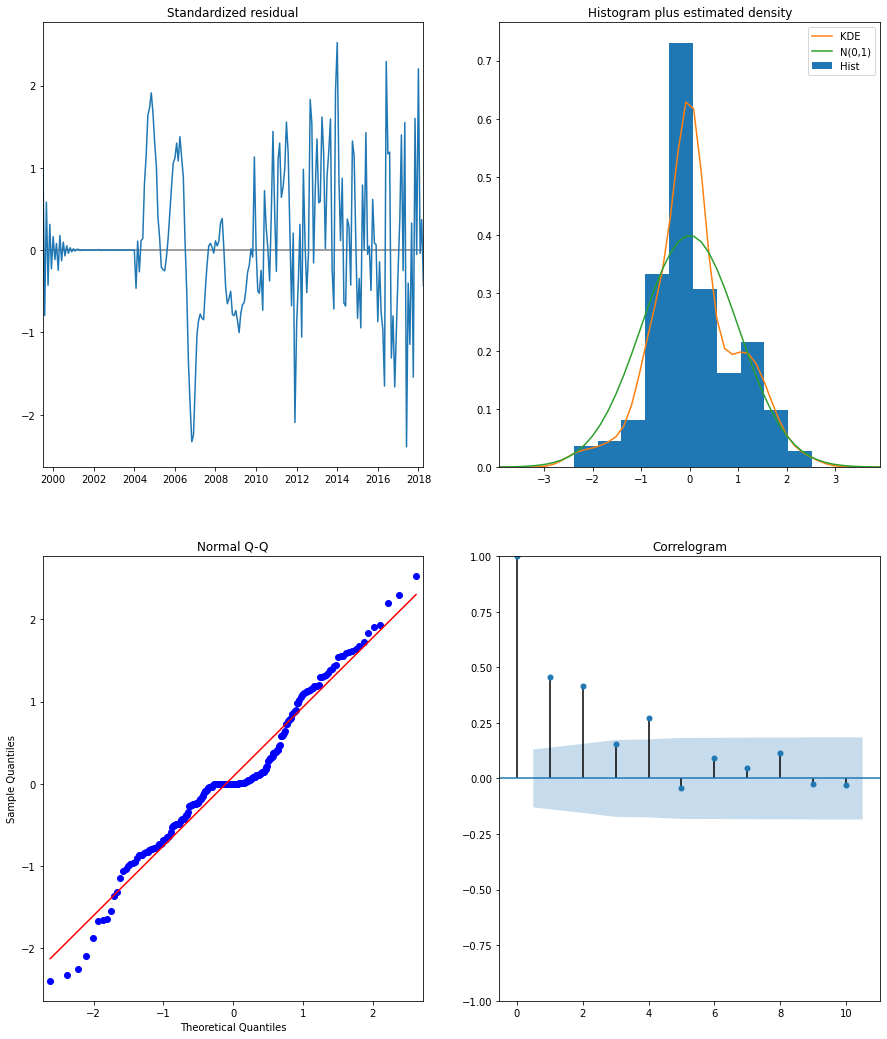

In [46]:

#11238	ARIMA(0,1,1)(1,1,2)[12] 
#output_su = fit_ARIMA(zip_df[11238], order=(0,1,1), seasonal_order=(1,1,2,12))
output_sarima = fit_ARIMA(zip_df[11238], order=(0,1,1), seasonal_order=(1,1,2,12))

### **Validating the Model**

#### **One-Step Ahead Forecasting**

In [47]:
train_brk[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

In [48]:
train_brk[11238].tail()

Month
2013-09-01    1613500.0
2013-10-01    1638400.0
2013-11-01    1640700.0
2013-12-01    1661500.0
2014-01-01    1709200.0
Freq: MS, Name: 11238, dtype: float64

In [49]:
test_brk[11238]

Month
2014-01-01    1709200.0
2014-02-01    1748800.0
2014-03-01    1773300.0
2014-04-01    1798700.0
2014-05-01    1818100.0
2014-06-01    1824000.0
2014-07-01    1839100.0
2014-08-01    1866300.0
2014-09-01    1895100.0
2014-10-01    1932700.0
2014-11-01    1968900.0
2014-12-01    1995500.0
2015-01-01    2015200.0
2015-02-01    2030400.0
2015-03-01    2037700.0
2015-04-01    2063100.0
2015-05-01    2094300.0
2015-06-01    2126300.0
2015-07-01    2156800.0
2015-08-01    2184800.0
2015-09-01    2213100.0
2015-10-01    2248100.0
2015-11-01    2276200.0
2015-12-01    2300800.0
2016-01-01    2320800.0
2016-02-01    2336000.0
2016-03-01    2340500.0
2016-04-01    2346900.0
2016-05-01    2343900.0
2016-06-01    2378300.0
2016-07-01    2437700.0
2016-08-01    2491200.0
2016-09-01    2515300.0
2016-10-01    2528600.0
2016-11-01    2530000.0
2016-12-01    2527600.0
2017-01-01    2537400.0
2017-02-01    2557000.0
2017-03-01    2585200.0
2017-04-01    2610400.0
2017-05-01    2639900.0
2017-06-01

In [50]:
"""
In order to validate model, start by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts

get_prediction() and .conf_int() methods allow us to obtain the values and associated confidence intervals for forecasts of the time series.
Get the confidence intervals for all predictions


year = '2014-01-01'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

pred = output_su.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()

"""
# Note: Get predictions starting from 01-01-1998 and calculate confidence intervals

pred = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [51]:
test_brk[11238]

Month
2014-01-01    1709200.0
2014-02-01    1748800.0
2014-03-01    1773300.0
2014-04-01    1798700.0
2014-05-01    1818100.0
2014-06-01    1824000.0
2014-07-01    1839100.0
2014-08-01    1866300.0
2014-09-01    1895100.0
2014-10-01    1932700.0
2014-11-01    1968900.0
2014-12-01    1995500.0
2015-01-01    2015200.0
2015-02-01    2030400.0
2015-03-01    2037700.0
2015-04-01    2063100.0
2015-05-01    2094300.0
2015-06-01    2126300.0
2015-07-01    2156800.0
2015-08-01    2184800.0
2015-09-01    2213100.0
2015-10-01    2248100.0
2015-11-01    2276200.0
2015-12-01    2300800.0
2016-01-01    2320800.0
2016-02-01    2336000.0
2016-03-01    2340500.0
2016-04-01    2346900.0
2016-05-01    2343900.0
2016-06-01    2378300.0
2016-07-01    2437700.0
2016-08-01    2491200.0
2016-09-01    2515300.0
2016-10-01    2528600.0
2016-11-01    2530000.0
2016-12-01    2527600.0
2017-01-01    2537400.0
2017-02-01    2557000.0
2017-03-01    2585200.0
2017-04-01    2610400.0
2017-05-01    2639900.0
2017-06-01

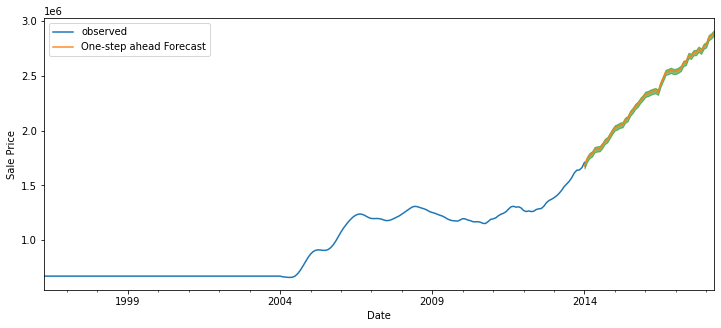

In [52]:
"""
plot the real and forecasted values of the time series to assess how well we did
Plot the confidence intervals overlapping the predicted values
The forecasts align with the true values as seen above, with overall increase trend.
"""
# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
ax = train_brk[11238]['1996':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [53]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

Also check for the accuracy of our forecasts using MSE (Mean Squared Error). This will provide us with the average error of our forecasts.

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal

Model was able to forecast the average daily real estate sales in the test set within 13,226.79 of the real sales. 
  sales range from around 659,200.000 to over 1,709,200.000.     
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test_brk[11238]['1996':]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 174947908.58
The Root Mean Squared Error of our forecasts is 13226.79


In [54]:
train_brk[11238].describe().round(3)

count        214.000
mean      959402.336
std       302419.952
min       659200.000
25%       671200.000
50%       900100.000
75%      1225725.000
max      1709200.000
Name: 11238, dtype: float64

### **Dynamic Forecasting**

In [55]:
"""
we only use information from the time series up to a certain point, 
  and after that, forecasts are generated using values from previous forecasted time points.

pred_dynamic = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

calculation for predictions post 2014.
"""
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [56]:
"""
Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. 
All forecasted values (yellow line) match pretty closely to the ground truth (blue line), 
  and are well within the confidence intervals of our forecast.
  
before used 2004
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()
"""

def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y['1996':].plot(label='observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  # Produce the forecasted tables 
  # pm = pred_dynamic.predicted_mean.reset_index()
  # pm.columns = ['Date','Predicted_Mean']
  # pci = pred_dynamic_conf.reset_index()
  # pci.columns = ['Date','Lower Bound','Upper Bound']
  # final_table = pm.join(pci.set_index('Date'), on='Date')
      
  #return final_table.head(5)
  return ax

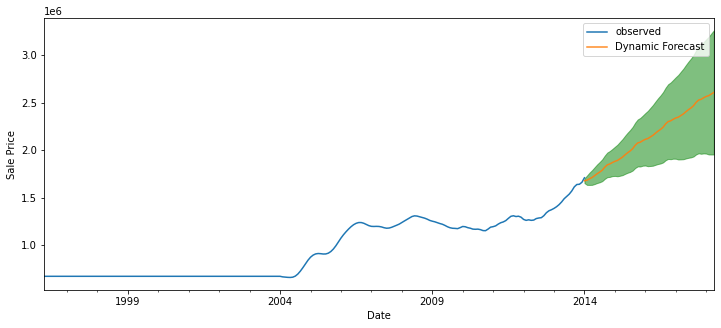

In [57]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train_brk[11238])
prediction_visual

In [58]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train_brk[11238]['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 990776159.12
The Root Mean Squared Error of our forecasts is 31476.6


### **Producing and Visualizing Forecasts**

In [59]:
"""
.get_forecast() method of our time series output can compute forecasted values for a specified number of steps ahead.

prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()
"""
# Get forecast --- steps ahead in future
prediction = output_sarima.get_forecast(steps=36, dynamic=True)

# Get confidence intervals of forecasts
predict_conf = prediction.conf_int()


In [71]:
prediction

In [60]:
type(train_brk[11238])

pandas.core.series.Series

In [61]:
def forecast_function(prediction, predict_conf, mod=train_brk[11238]):
  pm = prediction.predicted_mean.reset_index()
  pm.columns = ['Date','Predicted_Mean']
  pci = predict_conf.reset_index()
  pci.columns = ['Date','Lower Bound','Upper Bound']
  pm_table_1 = pm.join(pci.set_index('Date'), on='Date')
  pm_table_1.set_index('Date', inplace=True)
  #pm_table_1['Zipcode'] = mod
  pm_table_1 = pm_table_1.iloc[[0, -1]].round(3)
  pm_table_1['Date'] = pm_table_1.index
  #pm_table_1.set_index('Zipcode', inplace=True)

  return pm_table_1.round(3)

In [62]:
forecast_df = forecast_function(prediction, predict_conf, mod=train_brk[11238])
forecast_df

,Predicted_Mean,Lower Bound,Upper Bound,Date
Date,,,,
2018-05-01,2897897.929,2873437.426,2922358.433,2018-05-01
2021-04-01,3691242.669,3276148.024,4106337.313,2021-04-01


In [63]:
forecast_df.iloc[0]

Predicted_Mean             2.8979e+06
Lower Bound               2.87344e+06
Upper Bound               2.92236e+06
Date              2018-05-01 00:00:00
Name: 2018-05-01 00:00:00, dtype: object

In [64]:
train_brk[11238]

Month
1996-04-01     671200.0
1996-05-01     671200.0
1996-06-01     671200.0
1996-07-01     671200.0
1996-08-01     671200.0
                ...    
2013-09-01    1613500.0
2013-10-01    1638400.0
2013-11-01    1640700.0
2013-12-01    1661500.0
2014-01-01    1709200.0
Freq: MS, Name: 11238, Length: 214, dtype: float64

In [78]:
my_sam = []
for col in train_brk[11238]:
  my_sam.append(col)
  my_out = pd.DataFrame(my_sam)
print(my_out)

             0
0     671200.0
1     671200.0
2     671200.0
3     671200.0
4     671200.0
..         ...
209  1613500.0
210  1638400.0
211  1640700.0
212  1661500.0
213  1709200.0

[214 rows x 1 columns]


In [79]:
"""
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  #arima_dic_2[col] = zip_test_2
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df 
"""

my_test =[]
for col in train_brk[11238]:
  zip_test_2 = forecast_function(prediction, predict_conf,col)
  my_test.append([zip_test_2.Predicted_Mean,zip_test_2['Lower Bound'],zip_test_2['Upper Bound'],zip_test_2.Date ])

  output_df_1 = pd.DataFrame(my_test) 
  
print(output_df_1.head())

                                                   0  ...                                                  3
0  Date
2018-05-01    2897897.929
2021-04-01    3...  ...  Date
2018-05-01   2018-05-01
2021-04-01   2021...
1  Date
2018-05-01    2897897.929
2021-04-01    3...  ...  Date
2018-05-01   2018-05-01
2021-04-01   2021...
2  Date
2018-05-01    2897897.929
2021-04-01    3...  ...  Date
2018-05-01   2018-05-01
2021-04-01   2021...
3  Date
2018-05-01    2897897.929
2021-04-01    3...  ...  Date
2018-05-01   2018-05-01
2021-04-01   2021...
4  Date
2018-05-01    2897897.929
2021-04-01    3...  ...  Date
2018-05-01   2018-05-01
2021-04-01   2021...

[5 rows x 4 columns]


In [80]:
"""
# #arima_dic_2 = {}
# col = 11238
# #for col in zip_df.columns:
# zip_test_2 = arima_model(zip_df[col])
# #arima_dic_2[col] = zip_test_2
  
# # output_2 = pd.DataFrame(arima_dic_2.items(), columns =['Zipcode_pdq','pdq']) 
# # output_2   
"""
# arima_dic_3 = {}
# col = 11238
# for col in train_brk[11238]:
#   zip_test_3 = forecast_function(train_brk[col])
#   arima_dic_3[col] = zip_test_3
  
#   output_2 = pd.DataFrame(arima_dic_2.items(), columns =['Predicted_Mean','Lower Bound','Upper Bound','Date']) 
#   output_2   

"\n# #arima_dic_2 = {}\n# col = 11238\n# #for col in zip_df.columns:\n# zip_test_2 = arima_model(zip_df[col])\n# #arima_dic_2[col] = zip_test_2\n  \n# # output_2 = pd.DataFrame(arima_dic_2.items(), columns =['Zipcode_pdq','pdq']) \n# # output_2   \n"

In [81]:

def forecast_fu(prediction, predict_conf, mod):
  pm = prediction.predicted_mean.reset_index()
  pm.columns = ['Date','Predicted_Mean']
  pci = predict_conf.reset_index()
  pci.columns = ['Date','Lower Bound','Upper Bound']
  pm_table_1 = pm.join(pci.set_index('Date'), on='Date')
  pm_table_1.set_index('Date', inplace=True)
  pm_table_1['Zipcode'] = mod.name
  pm_table_1 = pm_table_1.iloc[[0, -1]].round(3)
  pm_table_1['Date'] = pm_table_1.index
  pm_table_1.set_index('Zipcode', inplace=True)
  #df = pd.concat([a_series, another_series], axis=1)
  #val_1 = pd.Series(pm_table_1.iloc[0]),
  #val_2 = pd.Series(pm_table_1.iloc[1]),
  #store = pd.concat([val_1,val_2], axis=1)

  return pm_table_1.round(3)

In [82]:
forecast_test = forecast_fu(prediction, predict_conf, mod=train_brk[11238])
forecast_test

,Predicted_Mean,Lower Bound,Upper Bound,Date
Zipcode,,,,
11238,2897897.929,2873437.426,2922358.433,2018-05-01
11238,3691242.669,3276148.024,4106337.313,2021-04-01


In [83]:
def forecast_fu(prediction, predict_conf, mod):
  pm = prediction.predicted_mean.reset_index()
  pm.columns = ['Date','Predicted_Mean']
  pci = predict_conf.reset_index()
  pci.columns = ['Date','Lower Bound','Upper Bound']
  pm_table_1 = pm.join(pci.set_index('Date'), on='Date')
  pm_table_1.set_index('Date', inplace=True)
  pm_table_1['Zipcode'] = mod.name
  pm_table_1 = pm_table_1.iloc[[0, -1]].round(3)
  pm_table_1['Date'] = pm_table_1.index
  pm_table_1.set_index('Zipcode', inplace=True)
  #df = pd.concat([a_series, another_series], axis=1)
  #val_1 = pd.Series(pm_table_1.iloc[0]),
  #val_2 = pd.Series(pm_table_1.iloc[1]),
  #store = pd.concat([val_1,val_2], axis=1)
  pm_table_1.reset_index(inplace=True)
  return pm_table_1.round(3)

In [84]:
forecast_test_1 = forecast_fu(prediction, predict_conf, mod=train_brk[11238])
forecast_test_1

,Zipcode,Predicted_Mean,Lower Bound,Upper Bound,Date
0,11238,2897897.929,2873437.426,2922358.433,2018-05-01
1,11238,3691242.669,3276148.024,4106337.313,2021-04-01


In [85]:
# val1 = forecast_test_1[0]
# val1 = pd.Series(val1)
# val1 = val1.T


In [86]:
# val2 = forecast_test_1.iloc[1]
# val2 = pd.DataFrame(val2)
# #df.rename(columns = {'$b':'B'}, in)
# val2 = val2.T
# val2 = val2.rename(columns= {'Zipcode':'Zipcode1','Predicted_Mean': 'Predicted_Mean1', 'Lower Bound': 'Lower Bound1','Upper Bound':'Upper Bound1','Date':'Date1'})
# store = pd.concat([val1,val2], axis=1)


In [87]:
# val2 = forecast_test_1.iloc[1]
# val2 = pd.DataFrame(val2)
# #df.rename(columns = {'$b':'B'}, in)
# val2 = val2.T
# val2 = val2.rename(columns= {'Zipcode':'Zipcode','Predicted_Mean': 'Predicted_Mean1', 'Lower Bound': 'Lower Bound1','Upper Bound':'Upper Bound1','Date':'Date'})
# #store = pd.concat([val1,val2], axis=1)

In [88]:
# forecast_test_1['Date'] = forecast_test_1.index
# forecast_test_1.set_index(['Zipcode', 'Date'], inplace=True)
# forecast_test_1

In [89]:
#forecast_test_1[''] = forecast_test_1['']['Predicted_Mean'] - forecast_test_1['Predicted_Mean']

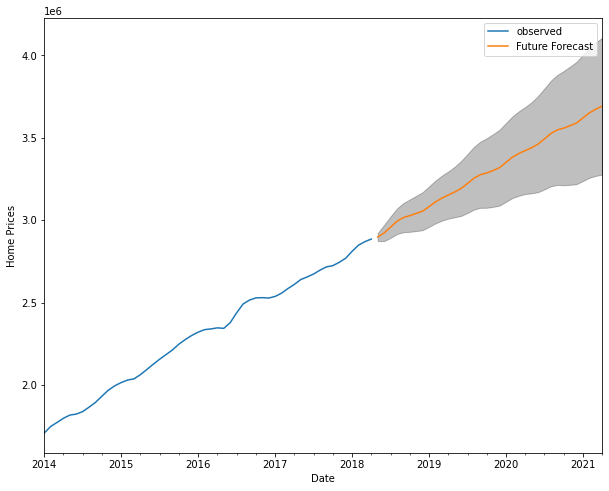

In [90]:
"""
train_bk ends: 2014-01-01    1709200.0
test_bk ends:  2018-04-01
"""
# Plot future predictions with confidence intervals
ax = test_brk[11238].plot(label='observed', figsize=(10, 8))
prediction.predicted_mean.plot(ax=ax, label='Future Forecast')
ax.fill_between(predict_conf.index,
                predict_conf.iloc[:, 0],
                predict_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Home Prices')

plt.legend()
plt.show()

In [91]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# mse = mean_squared_error(test_brk[11226], future_forecast)
# rmse = sqrt(mse)
# print(rmse)

## ***Stationarity***

### **Zipcode: 11226**

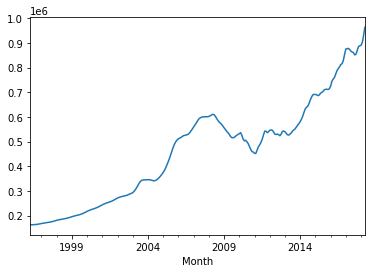

In [92]:
zip_df[11226].plot()

In [93]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

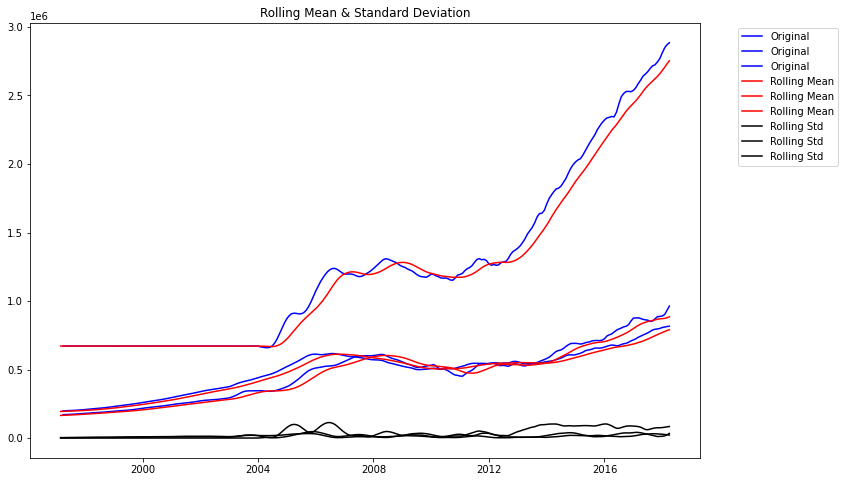

In [94]:
test_stationarity_1(zip_df,12)

In [95]:
#Not mine

def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    return dfoutput

In [96]:
new_dic = {}
for col in zip_df.columns:
  zip_test = dickey_fuller_test_ind_zip(zip_df[col])
  new_dic[col] = zip_test

(0.6254102589740158, 0.9882254867110694, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 4684.550681605726)
Results of Dickey-Fuller Test:
(-0.8284459621478661, 0.8106231633355563, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 4266.968811034178)
Results of Dickey-Fuller Test:
(1.3300142358520664, 0.9967718123702427, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 5045.970907033796)
Results of Dickey-Fuller Test:


In [97]:
new_dic[11226]

Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64

In [98]:

def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n')         

In [99]:
dickey_fuller_test_zipcodes(zip_df)

Results of Dickey-Fuller Test:
Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -0.828446
p-value                          0.810623
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                   1.330014
p-value                          0.996772
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -

In [100]:
X_1 = zip_df.copy()

In [101]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

ADF statistic: 0.6254102589740158
p-value: 0.9882254867110694
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.62541,0.988225,15,249,False


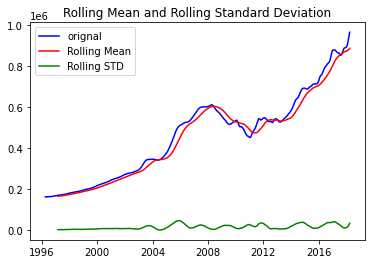

In [102]:
stationary_test(zip_df[11226])

###  Zipcode:  11238

In [103]:
#brooklyn_zips[11226]

In [104]:
#stationary_test(zip_df[11238])

### Zipcode:  11215

ADF statistic: 0.6254102589740158
p-value: 0.9882254867110694
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.62541,0.988225,15,249,False


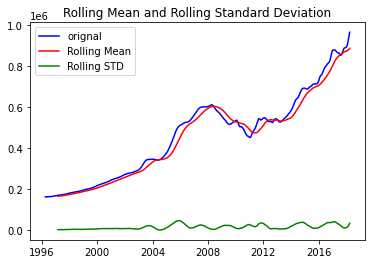

In [105]:
stationary_test(zip_df[11226])

### Removing Trend
#### Log-Transformation (np.log)

ADF statistic: -0.8965122806314395
p-value: 0.7891188037192421
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-0.896512,0.789119,15,249,False


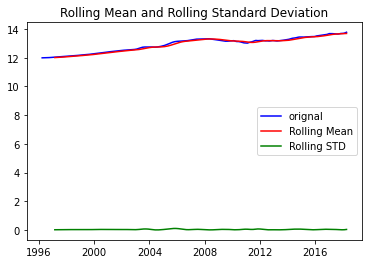

In [106]:
## Log Transform
ts3 = np.log(zip_df[11226])
#ts3.plot()
stationary_test(ts3)

#### Differencing

ADF statistic: -2.0776022749420107
p-value: 0.2536156786996234
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-2.077602,0.253616,14,249,False


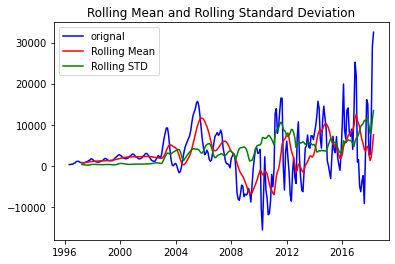

In [107]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11226].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

ADF statistic: -1.6919221784675216
p-value: 0.43527914575985843
Critical Values:
	1% : -3.457215237265747
	5% : -2.873361841566324
	10% : -2.5730700760129555


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.691922,0.435279,16,246,False


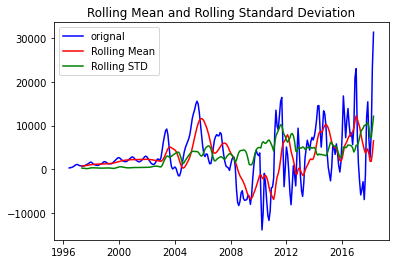

In [108]:
## Subtract Rolling mean
ts2 = (zip_df[11226] - zip_df[11226].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

ADF statistic: -1.386161098795962
p-value: 0.5888923863309314
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.386161,0.588892,15,249,False


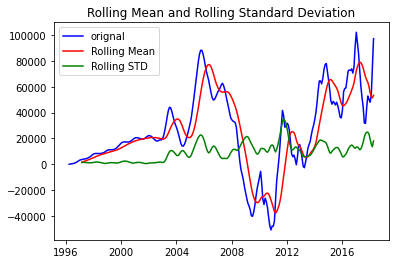

In [109]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11226] - zip_df[11226].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

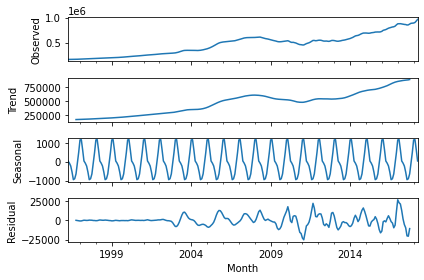

In [110]:
"""
it will identfies patterns, trends in ts and separate them into 3 new ts.
residual-what was left over after removing all the other components.
"""
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11226])#,model='mul')
decomp.plot();

ADF statistic: -861210761297677.1
p-value: 0.0
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-8.612108e+14,0.0,15,249,True


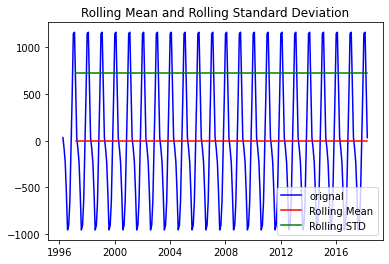

In [111]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

ADF statistic: 0.70406044441254
p-value: 0.9899185553239883
Critical Values:
	1% : -3.4583663275730476
	5% : -2.8738660999177132
	10% : -2.5733390785693766


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.70406,0.989919,16,236,False


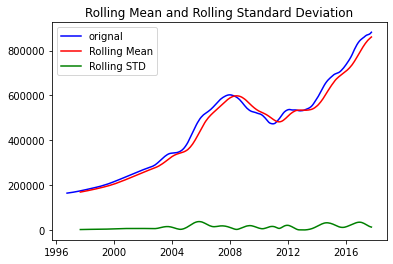

In [112]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

ADF statistic: -4.680890205249196
p-value: 9.139086370903546e-05
Critical Values:
	1% : -3.4583663275730476
	5% : -2.8738660999177132
	10% : -2.5733390785693766


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-4.68089,0.000091,16,236,True


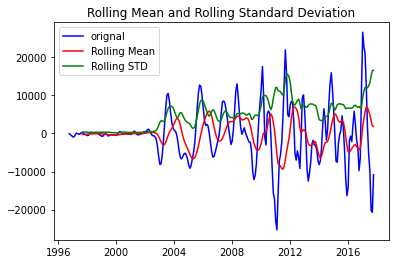

In [113]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [114]:
decomp.resid.dropna()

Month
1996-10-01      -66.765873
1996-11-01     -359.478716
1996-12-01     -561.859668
1997-01-01     -915.827922
1997-02-01     -855.113636
                  ...     
2017-06-01    -5596.978716
2017-07-01    -9750.550144
2017-08-01   -20252.534271
2017-09-01   -20681.700938
2017-10-01   -10825.099206
Freq: MS, Name: 11226, Length: 253, dtype: float64

#### Return on Investment

In [115]:
investment = 40000
rent = 700
loss = 1000  #cost of 1000 per year

def roi(investment, rent, loss):
    """
    return on investment is calcualted by net_profit / investment * 100
    12 = # of months in year 
    investment part doesn't need to be touched investment amount is just capital cost of building
    """
    netprofit = rent * 12 - loss
    ROI = (netprofit / investment) * 100
    print(ROI)
    
#roi(investment, rent, loss) 
#calculated return on investment for these parameters
roi(investment, rent, loss)   

18.5


### **RNN**

In [116]:
df_rnn = zip_df[[11238]]

In [117]:
df_rnn.head()

,11238
Month,
1996-04-01,671200.0
1996-05-01,671200.0
1996-06-01,671200.0
1996-07-01,671200.0
1996-08-01,671200.0


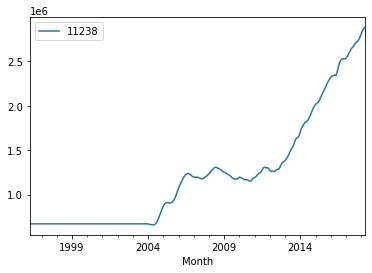

In [118]:
df_rnn.plot()

In [119]:
len(df_rnn)

265

In [120]:
265-12

253

In [121]:
"""
x_train= x_train.reshape(-1, 1)
y_train= y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
"""
train = df_rnn.iloc[:253]
test = df_rnn.iloc[253:]
#test = test.reshape(1, -1)
#train= train.reshape(-1, 1)

In [122]:
test

,11238
Month,
2017-05-01,2639900.0
2017-06-01,2655700.0
2017-07-01,2673300.0
2017-08-01,2696700.0
2017-09-01,2716500.0
2017-10-01,2724000.0
2017-11-01,2744300.0
2017-12-01,2768900.0
2018-01-01,2810700.0


In [123]:
len(test)

12

In [124]:
train.shape

(253, 1)

In [125]:
from sklearn.preprocessing import MinMaxScaler

In [126]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [127]:
scaled_train

array([[6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],


In [128]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [129]:
n_input = 2
n_features = 1 #smaller batch sizes lead to better training

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [130]:
scaled_train[:5]

array([[0.00615006],
       [0.00615006],
       [0.00615006],
       [0.00615006],
       [0.00615006]])

In [131]:
len(scaled_train)

253

In [132]:
"""

253 - n_input(2)

"""
len(generator)

251

In [133]:
#create model and fit it to the generator object
from keras.models import Sequential
from keras.layers import Dense  #for final output later
from keras.layers import LSTM #long short term memory

In [134]:
n_input = 12 #look at full year of data or 12 months before predicting 13th month
n_features = 1 #smaller batch sizes lead to better training
               #how many columns you have. WE have 1 column which is time stamp for y

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [135]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
#need to aggregate all the neurons to sngle prediciton
model.add(Dense(1)) #added single dense neuron which will directly output our prediction
model.compile(optimizer='adam', loss='mse')

In [136]:
"""
may want to play around w/number of neurons on LSTM layer
"""
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [137]:
"""
fit tou our training generator
more epochs you use hte longer it's going to take to train
1 epoch is a single entire run through of training data

We get significant reduciton over 1st couple of epochs then around 15 start seeing convergence

"""
model.fit_generator(train_generator, epochs=25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
241/241 [==============================] - 5s 19ms/step - loss: 0.0150
Epoch 2/25
241/241 [==============================] - 5s 19ms/step - loss: 0.0021
Epoch 3/25
241/241 [==============================] - 5s 21ms/step - loss: 9.8727e-04
Epoch 4/25
241/241 [==============================] - 5s 19ms/step - loss: 0.0011
Epoch 5/25
241/241 [==============================] - 5s 21ms/step - loss: 0.0012
Epoch 6/25
241/241 [==============================] - 5s 20ms/step - loss: 8.7252e-04
Epoch 7/25
241/241 [==============================] - 5s 20ms/step - loss: 6.0252e-04
Epoch 8/25
241/241 [==============================] - 5s 19ms/step - loss: 4.7393e-04
Epoch 9/25
241/241 [==============================] - 5s 19ms/step - loss: 6.5771e-04
Epoch 10/25
241/241 [==============================] - 5s 20ms/step - loss: 0.0011
Epoch 11/25
241/241 [==============================] - 5s 21ms/step - loss: 4.8612e

In [138]:
model.history.history.keys()

dict_keys(['loss'])

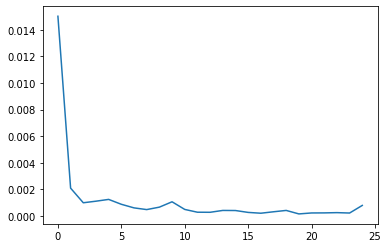

In [139]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss']);

In [140]:
"""
evalute on the test data
create an evlauation batch
our network trains 1 step ahead

our network is 12 network steps 
    then predict step 13
    
need last 12 points of training data inorder to predict pt. 1 of test data 

these are last 12 points of training set
"""
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.86341738],
       [0.88104756],
       [0.91149036],
       [0.93890939],
       [0.95126076],
       [0.95807708],
       [0.95879459],
       [0.95756458],
       [0.96258713],
       [0.97263223],
       [0.98708487],
       [1.        ]])

In [141]:
"""
it now has 3 brackets at the top
"""
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))
first_eval_batch

array([[[0.86341738],
        [0.88104756],
        [0.91149036],
        [0.93890939],
        [0.95126076],
        [0.95807708],
        [0.95879459],
        [0.95756458],
        [0.96258713],
        [0.97263223],
        [0.98708487],
        [1.        ]]])

In [142]:
"""
call model on first_eval_batch
gives array prediciton
means given these 12 points of training data it predicts taht below should be 1st point of test data set
"""
model.predict(first_eval_batch)

array([[0.98128027]], dtype=float32)

In [143]:
scaled_test

array([[1.0151189 ],
       [1.02321648],
       [1.03223657],
       [1.04422919],
       [1.05437679],
       [1.05822058],
       [1.06862444],
       [1.08123206],
       [1.10265478],
       [1.12182247],
       [1.13284133],
       [1.14088766]])

In [144]:
"""
not just predict 1st point in test set but the entire test set
how to forecast into the future
Forecast using RNN model
"""
#hold predicitons
test_predictions = []
#last n_input points from training set
first_eval_batch = scaled_train[-n_input:] 
#reshape to format of RNN wants, (same format as Timeseriesgenerator 
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#hoe far into the futrue will I forecast: length of test set
for i in range(len(test)):
    #1time step ahead of historical 12 points
    current_pred = model.predict(current_batch)[0] #0 is for formatting 
    test_predictions.append(current_pred)
    
    #update current batch to include prediciton
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [145]:
test_predictions

[array([0.98128027], dtype=float32),
 array([0.97843033], dtype=float32),
 array([0.969095], dtype=float32),
 array([0.95654356], dtype=float32),
 array([0.9428978], dtype=float32),
 array([0.92824394], dtype=float32),
 array([0.91192704], dtype=float32),
 array([0.8943288], dtype=float32),
 array([0.87591857], dtype=float32),
 array([0.8568258], dtype=float32),
 array([0.83728707], dtype=float32),
 array([0.81731826], dtype=float32)]

In [146]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[2573874.05743599],
       [2568313.26136589],
       [2550098.14777374],
       [2525607.80363083],
       [2498982.18078613],
       [2470389.56618309],
       [2438552.04901695],
       [2404214.30191994],
       [2368292.30828285],
       [2331038.55667114],
       [2292914.5277977 ],
       [2253951.39021873]])

In [147]:
test['Predictions'] = true_predictions

In [148]:
test

,11238,Predictions
Month,,
2017-05-01,2639900.0,2.573874e+06
2017-06-01,2655700.0,2.568313e+06
2017-07-01,2673300.0,2.550098e+06
2017-08-01,2696700.0,2.525608e+06
2017-09-01,2716500.0,2.498982e+06
2017-10-01,2724000.0,2.470390e+06
2017-11-01,2744300.0,2.438552e+06
2017-12-01,2768900.0,2.404214e+06
2018-01-01,2810700.0,2.368292e+06


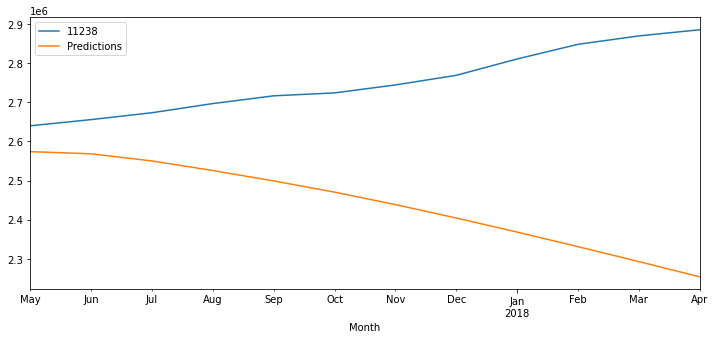

In [149]:
"""
sales v predicted values
"""
test.plot(figsize=(12,5));